In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.cluster.hierarchy as hc
import sys
sys.path
sys.path.append('./dave/diffimg/')
import tessprf as prf
from scipy import signal
from scipy import interpolate
from scipy.ndimage.filters import convolve
from scipy.signal import fftconvolve
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

In [4]:
def centroid(timespan, fluxarr, mask):
   # inputs: length of flux array, flux array (3 dimensional), aperture mask for centroiding over only target
    x_cent = np.zeros(timespan)
    y_cent = np.zeros(timespan)
    for i in range(timespan):
        xfsum = 0
        yfsum = 0
        fsum = 0
        temp = fluxarr[i,:]
        for index, val in np.ndenumerate(temp):
            if mask[index] == 3:
                xfsum += index[1] * temp[index]
                yfsum += index[0] * temp[index]
                fsum += temp[index]
            else:
                pass
        x_cent[i] = xfsum / fsum
        y_cent[i] = yfsum / fsum
    return x_cent, y_cent

def centroid_nomask(timespan, fluxarr):
    # inputs: length of flux array, flux array (3 dimensional), aperture mask for centroiding over only target
    x_cent = np.zeros(timespan)
    y_cent = np.zeros(timespan)
    for i in range(timespan):
        xfsum = 0
        yfsum = 0
        fsum = 0
        temp = fluxarr[i,:]
        for index, val in np.ndenumerate(temp):
            xfsum += index[1] * temp[index]
            yfsum += index[0] * temp[index]
            fsum += temp[index]
        x_cent[i] = xfsum / fsum
        y_cent[i] = yfsum / fsum
    return x_cent, y_cent

In [3]:
tess = np.load('tess.npy')
ps1_full = np.load('PS1.npy')
ps1 = ps1_full[0]
ps1_re = np.load('PS1_regrid.npy')

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


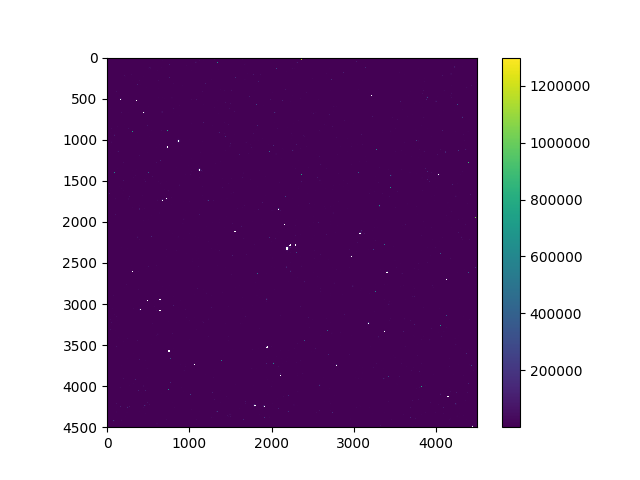

In [4]:
# when getting new PS image, replace with ps2tessCts function - this example will not have correct TESS mags
# limiting_g = np.power(10, -(22 - 25)/2.5)
limiting_g = 16
ps1[ps1 <= 0] = limiting_g
# ps1 = -2.5*np.log10(ps1) + 25

# NOT working in magnitudes

%matplotlib notebook
plt.imshow(ps1)
plt.colorbar()

In [5]:
kernel = Gaussian2DKernel(x_stddev=5)
ps1_fixed = convolve(ps1, kernel, boundary='extend')

<IPython.core.display.Javascript object>


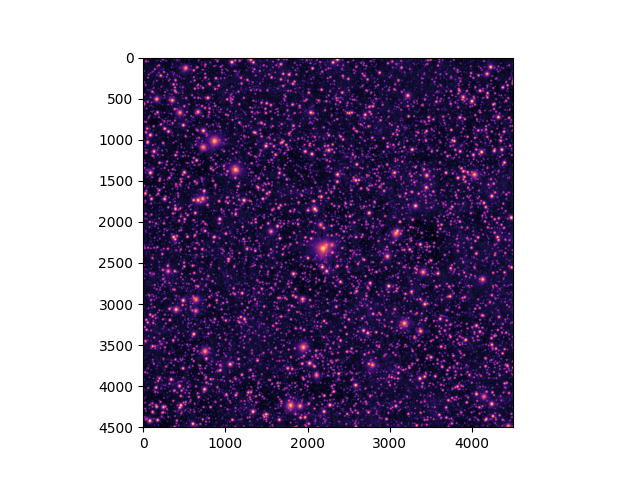

In [42]:
%matplotlib notebook

plt.imshow(ps1_fixed, norm=LogNorm(), cmap='magma')

<IPython.core.display.Javascript object>


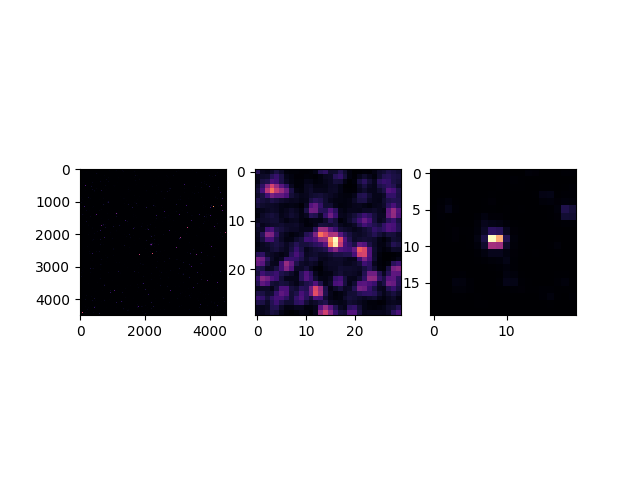

In [47]:
%matplotlib notebook

fig, ax = plt.subplots(1,3)
ax[0].imshow(ps1_fixed, cmap='magma')
ax[1].imshow(ps1_re, cmap='magma')
ax[2].imshow(tess, cmap='magma')

<IPython.core.display.Javascript object>


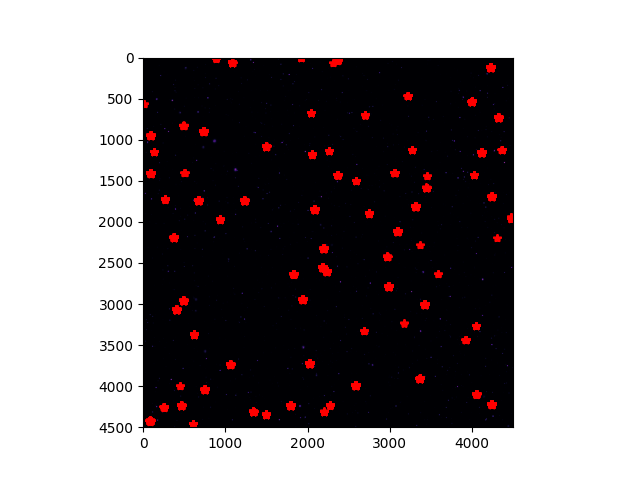

In [33]:
sources_x = np.zeros(0)
sources_y = np.zeros(0)
sourcemask = np.zeros(ps1_fixed.shape)
ps1_range = np.nanmax(ps1_fixed) - np.nanmin(ps1_fixed)
range_cut = ps1_range * 0.4 + np.nanmin(ps1_fixed)

# print(np.nanmax(ps1_fixed), np.nanmin(ps1_fixed), ps1_range, range_cut)

s = np.where(ps1_fixed>=range_cut)
sources_x = s[1]
sources_y = s[0]

# for index, val in np.ndenumerate(ps1_fixed):
#     if val>=range_cut:
# #         plt.plot(index[1], index[0], 'r*')
#         sources_x = np.append(sources_x, index[1])
#         sources_y = np.append(sources_y, index[0])
#         sourcemask[index] += 1

%matplotlib notebook
plt.imshow(ps1_fixed, cmap='magma')
plt.plot(sources_x, sources_y, 'r*')

In [179]:
print(f'looking at sources brighter than {range_cut:.3f} counts; others are likely to be greatly diluted')

looking at sources brighter than 126884.164 counts; others are likely to be greatly diluted


In [9]:
sources = np.c_[sources_x, sources_y]
clusters = hc.fclusterdata(sources, 1, criterion="distance")

<IPython.core.display.Javascript object>


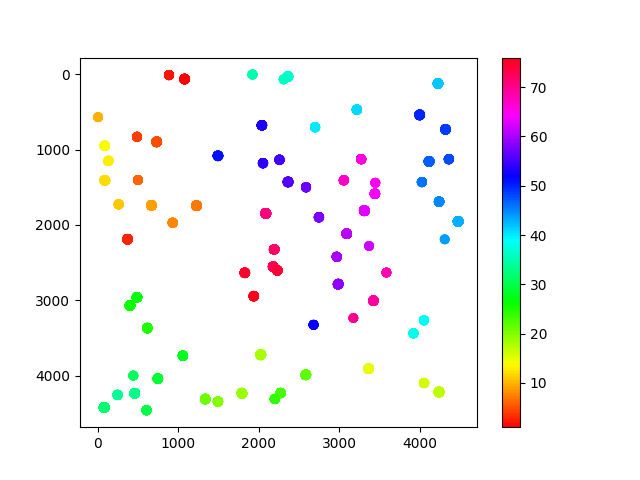

In [63]:
%matplotlib notebook

plt.scatter(sources_x, sources_y, c=clusters, cmap='hsv')
plt.gca().invert_yaxis()
plt.colorbar()

<IPython.core.display.Javascript object>


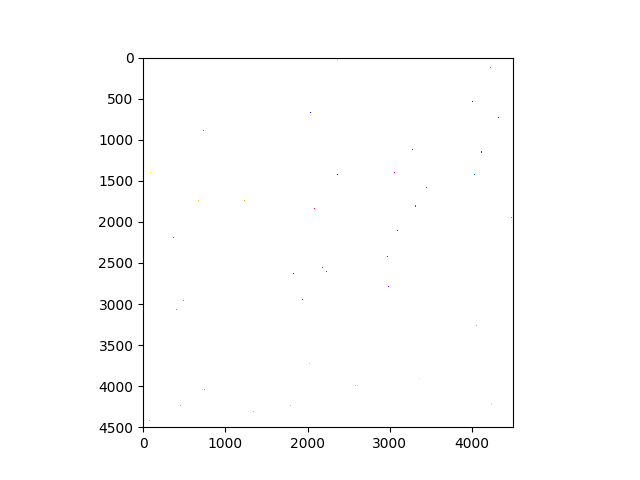

In [64]:
source_img = np.zeros(ps1.shape)
for i, val in enumerate(clusters):
    source_img[int(sources_y[i]), int(sources_x[i])] += val
    
%matplotlib notebook
cmap = plt.cm.hsv
cmap.set_under(color='white')
plt.imshow(source_img, cmap=cmap, vmin=0.00001)

<IPython.core.display.Javascript object>


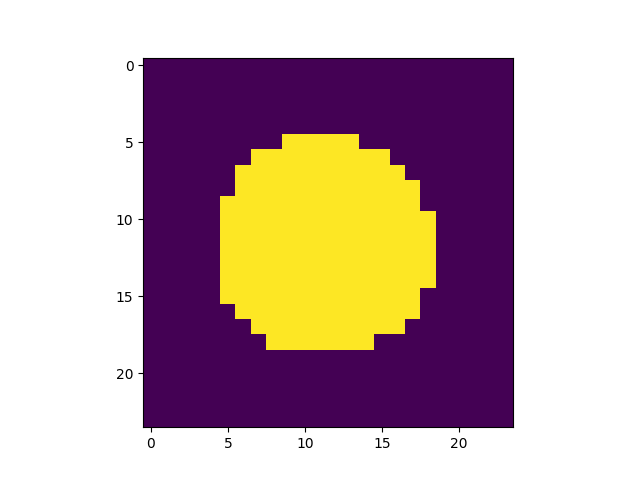

In [65]:
# clusters # main 72, then 5 top left
cluster = 5
box = np.argwhere(source_img==cluster)
expand = 5
max_x = max(box[:,1])+expand+1
min_x = min(box[:,1])-expand
max_y = max(box[:,0])+expand+1
min_y = min(box[:,0])-expand
cutout = source_img[min_y:max_y,min_x:max_x]
for i, val in np.ndenumerate(cutout):
    if val != cluster:
        cutout[i] = 0

%matplotlib notebook
plt.imshow(cutout)

In [24]:
# source_array = np.zeros((ps1.shape[0], ps1.shape[1], max(clusters)))
# bg_val = 1

# box = np.argwhere(source_img==cluster)
# out_box = np.argwhere(source_img!=cluster)
# for j in range(out_box.shape[0]):
#     source_array[out_box[j,:],cluster] += bg_val

<IPython.core.display.Javascript object>


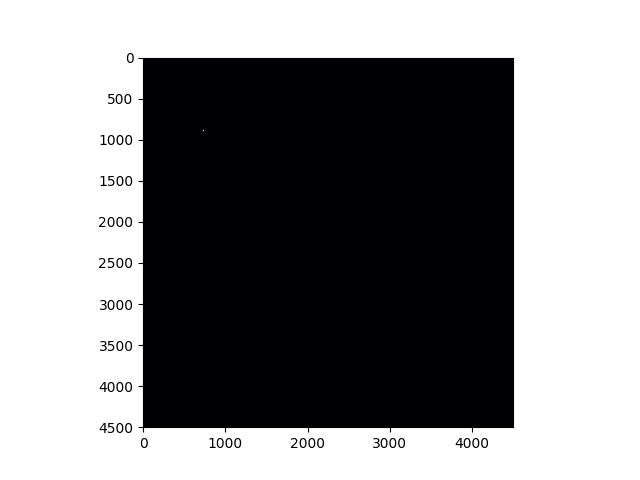

In [66]:
full_mask = np.zeros(ps1_fixed.shape) + limiting_g

box = np.argwhere(source_img==cluster)
expand = 100 # this parameter will have to change depending on stellar magnitude
max_x = max(box[:,1])+expand+1
min_x = min(box[:,1])-expand
max_y = max(box[:,0])+expand+1
min_y = min(box[:,0])-expand

full_mask[min_y:max_y, min_x:max_x] = ps1_fixed[min_y:max_y, min_x:max_x]

%matplotlib notebook
plt.imshow(full_mask, cmap='magma')

In [21]:
def Interp_PRF(X,Y,Camera,CCD):
    pathToMatFile = './data/prf/'
    obj = prf.TessPrf(pathToMatFile)
    PRF = obj.getPrfAtColRow(123.0, 456, 1,Camera,CCD)
    x2 = np.arange(0,PRF.shape[1]-1,0.01075)
    y2 = np.arange(0,PRF.shape[0]-1,0.01075)

    x = np.arange(0,PRF.shape[1],1)
    y = np.arange(0,PRF.shape[0],1)
    X, Y = np.meshgrid(x,y)

    x=X.ravel()              #Flat input into 1d vector
    y=Y.ravel()

    z = PRF
    z = z.ravel()
    x = list(x[np.isfinite(z)])
    y = list(y[np.isfinite(z)])
    z = list(z[np.isfinite(z)])

    znew = interpolate.griddata((x, y), z, (x2[None,:], y2[:,None]), method='cubic')
    kernal = znew
    return kernal

In [67]:
kernel = Interp_PRF(100,200,1,2)
test = fftconvolve(full_mask,kernel)

<IPython.core.display.Javascript object>


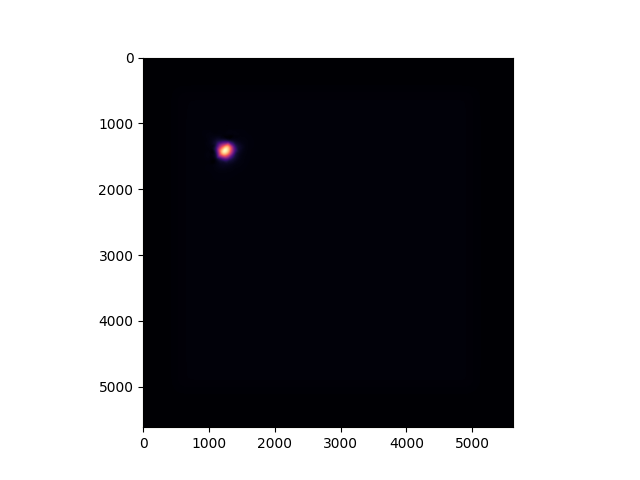

In [68]:
%matplotlib notebook
plt.imshow(test, cmap='magma')

In [55]:
def Downsample(PSconv):
	"""
	Downsamples the PS image to the resolution of TESS.
	Inputs
    ------
    PSconv: array like
    	The PS image convolved with the TESS PSF
	Returns
	-------
	TESS_resolution: array like
		The PS image reduced to the TESS resolution
	"""
	PSpixel = 0.021 # arcseconds per pixel 
	TESSpixel = 21 # arcseconds per pixel 
	Scale = 100#TESSpixel/PSpixel
	xnew = np.arange(PSconv.shape[1]/Scale)
	ynew = np.arange(PSconv.shape[0]/Scale)
	TESS_resolution = np.zeros((int(PSconv.shape[0]/Scale),int(PSconv.shape[1]/Scale)))
	for i in range(len(ynew)-1):
		ystart = int(i*Scale)
		yend = int(ystart + Scale)
		for j in range(len(xnew)-1):
			xstart = int(j*Scale)
			xend = int(xstart + Scale)
			TESS_resolution[i,j] = np.nansum(PSconv[ystart:yend,xstart:xend])
	return TESS_resolution

<IPython.core.display.Javascript object>


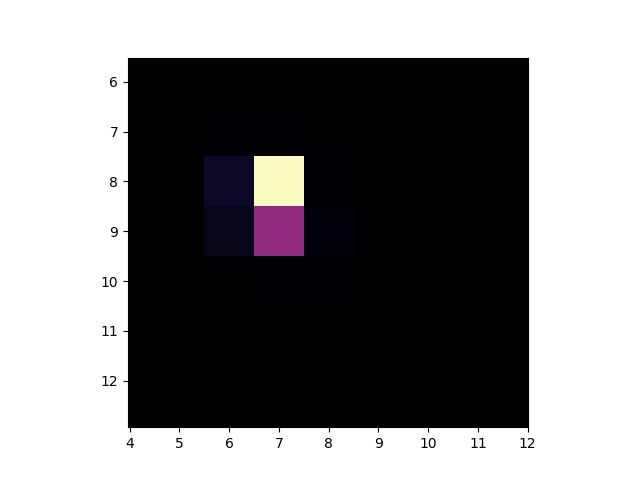

In [69]:
# import scipy.interpolate as spi

oldx = full_mask.shape[1]
oldy = full_mask.shape[0]
newx = tess.shape[1]
newy = tess.shape[0]

# interpolant = spi.RectBivariateSpline(np.arange(oldy), np.arange(oldx), full_mask, kx=3, ky=3)
# mask_rg = interpolant(np.linspace(0, oldy, newy), np.linspace(0, oldx, newx))
mask_rg = Downsample(full_mask)

# print(mask_rg)

%matplotlib notebook
plt.imshow(mask_rg, cmap='magma')